In [24]:
import sqlite3
from sqlite3 import Error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture

In [25]:
#Connect to database
try:
    conn = sqlite3.connect("project_data.sqlite")
    conn.text_factory = str
except Error as e:
    print("Error occurred: " + str(e))

In [26]:
#Read TRACTS table
TRACTS= pd.read_sql_query("SELECT * FROM TRACTS", conn)

In [27]:
#Extract features to be considered
TRACTS_= TRACTS[['IncomeDisparityE','UnemploymentRateE','P_UninsuredE','P_WithADisabilityE','MedianHouseholdIncomeE','MedianHomePriceE','P_NoVehicleAvailableE','P_NonWhiteE','P_RentBurdenedE','P_SingleParentHouseholdE','total_clinicians']]
#Remove rows with incomplete information
TRACTS_Ex= TRACTS_[TRACTS_.isnull().any(1)]
TRACTS_f= TRACTS.merge(TRACTS_Ex, how='left', indicator=True)
TRACTS_f= TRACTS_f[TRACTS_f['_merge']=='left_only']
TRACTS_ll= TRACTS_f[['GEOID','lat','lon']]                 
TRACTS_f= TRACTS_f[['IncomeDisparityE','UnemploymentRateE','P_UninsuredE','P_WithADisabilityE','MedianHouseholdIncomeE','MedianHomePriceE','P_NoVehicleAvailableE','P_NonWhiteE','P_RentBurdenedE','P_SingleParentHouseholdE','total_clinicians']]
TRACTS_ll.index= [i for i in range(len(TRACTS_ll))]
TRACTS_f.index= [i for i in range(len(TRACTS_f))]

In [28]:
#Find optimal number of clusters
bic= []
for i in range(2,12):
    clf= GaussianMixture(n_components=i, random_state=0).fit(TRACTS_f)
    bic.append(clf.bic(TRACTS_f))

Text(0, 0.5, 'BIC')

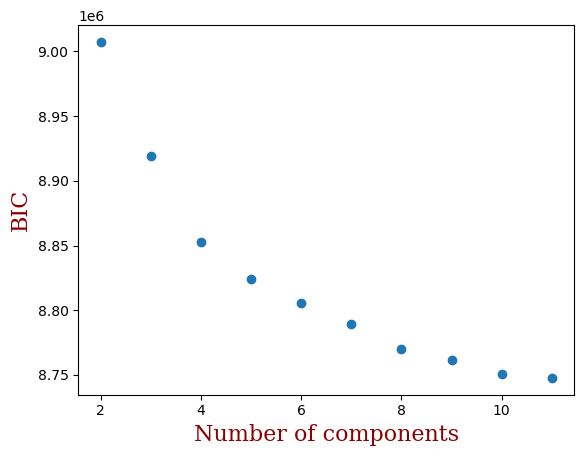

In [50]:
#plot bic against number of components
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
plt.scatter([i for i in range(2,12)],bic)
plt.xlabel('Number of components', fontdict=font)
plt.ylabel('BIC', fontdict=font)

In [30]:
#optimal number of components- 2
gm= GaussianMixture(n_components=2, random_state=0).fit(TRACTS_f)
y_pred= gm.predict(TRACTS_f)

In [31]:
#Export values to database
df_y_pred= pd.DataFrame(y_pred, columns={'y_pred'})
res= pd.concat([TRACTS_ll,TRACTS_f, df_y_pred], axis=1)
res= TRACTS.merge(res, how='left', left_on='GEOID', right_on='GEOID', indicator=True)
res=res[['index','GEOID', 'NAME', 'IncomeDisparityE_x', 'UnemploymentRateE_x', 'P_UninsuredE_x', 'P_WithADisabilityE_x','MedianHouseholdIncomeE_x','MedianHomePriceE_x','P_NoVehicleAvailableE_x','state','P_NonWhiteE_x','P_RentBurdenedE_x','P_SingleParentHouseholdE_x','total_clinicians_x','lat_x','lon_x','y_pred_y']]
res= res.rename(columns={'IncomeDisparityE_x':'IncomeDisparityE', 'UnemploymentRateE_x':'UnemploymentRateE', 'P_UninsuredE_x':'P_UninsuredE', 'P_WithADisabilityE_x':'P_WithADisabilityE','MedianHouseholdIncomeE_x':'MedianHouseholdIncomeE' ,'MedianHomePriceE_x':'MedianHomePriceE','P_NoVehicleAvailableE_x':'P_NoVehicleAvailableE','P_NonWhiteE_x':'P_NonWhiteE','P_RentBurdenedE_x':'P_RentBurdenedE','P_SingleParentHouseholdE_x':'P_SingleParentHouseholdE','total_clinicians_x':'total_clinicians','lat_x':'lat','lon_x':'lon','y_pred_y':'y_Pred' })
res.to_sql(name='TRACT_y', con=conn, if_exists= 'replace')
# conn.commit()

84414

In [37]:
print('means-',gm.means_)
print('covariance-',gm.covariances_)
print('Weights of components-',gm.weights_)

means- [[4.07790549e-01 4.81188578e+00 8.23502017e+00 1.40751118e+01
  7.09270635e+04 2.16909260e+05 4.61561122e+00 2.06238667e+01
  4.41009002e+01 5.64096647e+00 5.86666517e+02]
 [4.38705613e-01 7.22199139e+00 9.76779292e+00 1.21828744e+01
  8.07092102e+04 4.41795907e+05 1.39214607e+01 4.76717763e+01
  5.16785026e+01 7.85865053e+00 3.00901008e+03]]
covariance- [[[ 3.68544667e-03  1.72395651e-02  3.12367952e-02  9.07259383e-02
   -5.43116655e+02 -6.71491908e+02  7.15998627e-02 -5.17473412e-02
    2.07809822e-01  4.30021548e-03 -7.48340498e+00]
  [ 1.72395651e-02  1.03031156e+01  3.23195196e+00  4.41501847e+00
   -2.16059857e+04 -6.07472095e+04  2.24751221e+00  9.59602129e+00
    7.69600294e+00  1.86586066e+00 -1.33044077e+02]
  [ 3.12367952e-02  3.23195196e+00  3.47410027e+01  5.77623573e+00
   -6.45659739e+04 -2.11028513e+05  3.13386963e+00  3.37650498e+01
    7.28541486e+00  5.35050492e+00 -3.99364068e+02]
  [ 9.07259383e-02  4.41501847e+00  5.77623573e+00  3.36546567e+01
   -8.69089

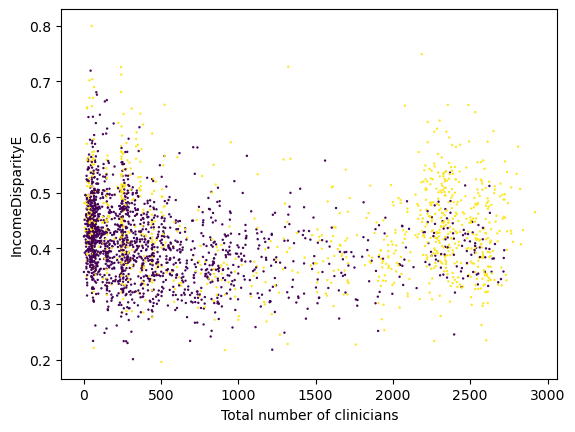

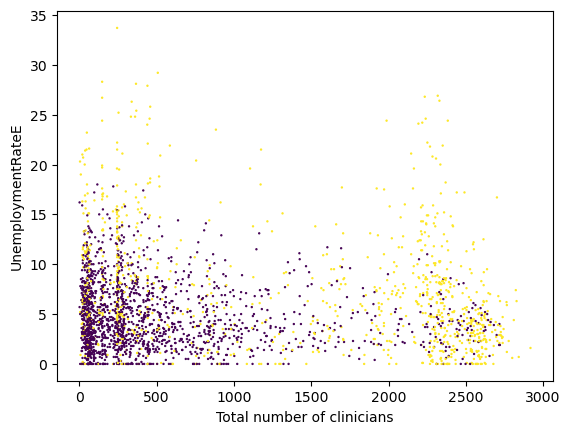

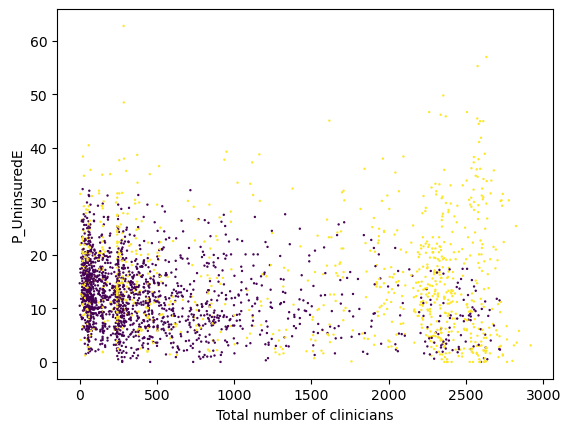

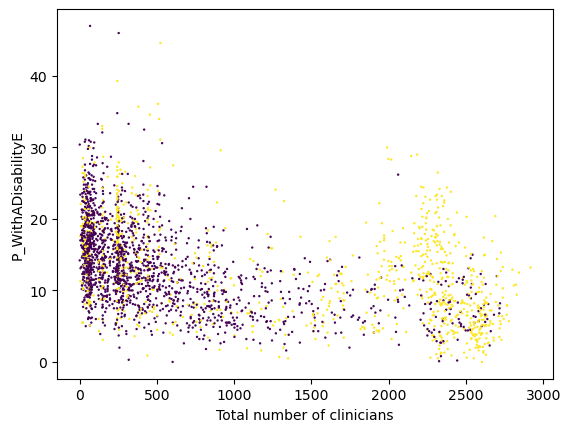

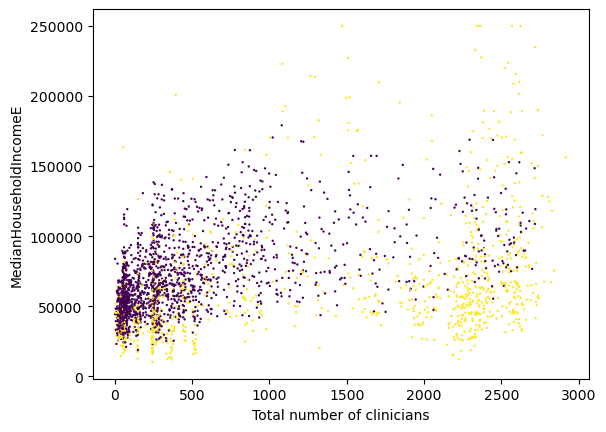

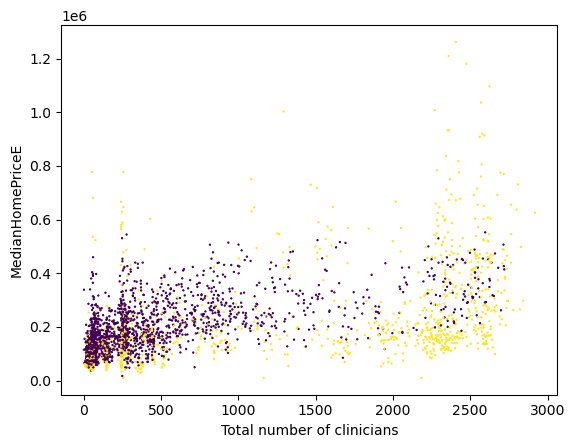

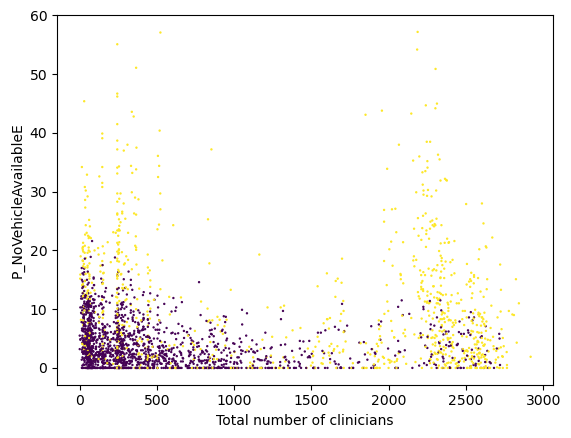

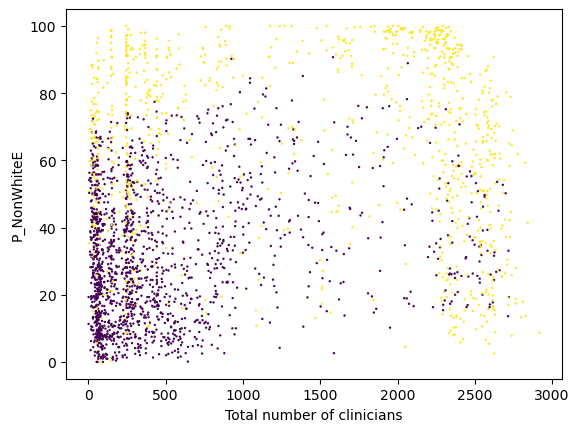

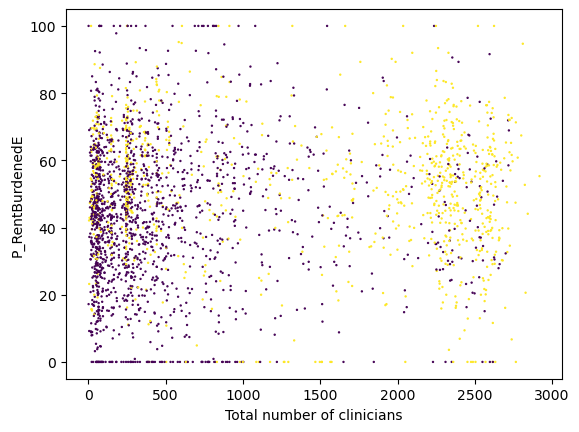

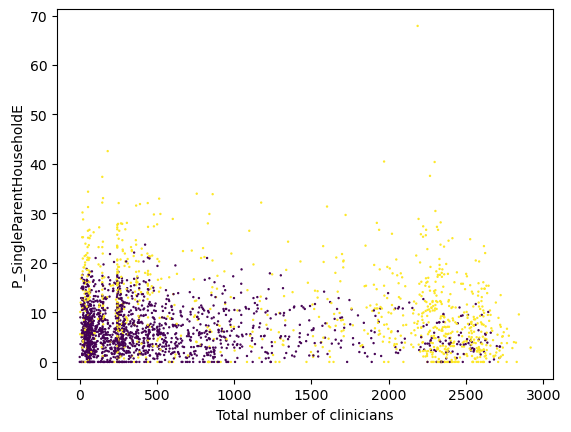

In [68]:
#Visualization for Georgia
TRACTS_ga= res[res['state']=='GA']
TRACTS_ga= TRACTS_ga[['IncomeDisparityE','UnemploymentRateE','P_UninsuredE','P_WithADisabilityE','MedianHouseholdIncomeE','MedianHomePriceE','P_NoVehicleAvailableE','P_NonWhiteE','P_RentBurdenedE','P_SingleParentHouseholdE','total_clinicians','y_Pred']]
TRACTS_ga_Ex= TRACTS_ga[TRACTS_ga.isnull().any(1)]
TRACTS_ga_f= TRACTS_ga.merge(TRACTS_ga_Ex, how='left', indicator=True)
TRACTS_ga_f= TRACTS_ga_f[TRACTS_ga_f['_merge']=='left_only']
col= TRACTS_ga_f.columns

for i in range(len(col)-3):
    plt.figure()
    plt.scatter(TRACTS_ga_f.iloc[:,10],TRACTS_ga_f.iloc[:,i],c=TRACTS_ga_f.iloc[:,11],s=0.5)
    plt.xlabel("Total number of clinicians")
    plt.ylabel(col[i])